## <center> LSTM Hyperparameters Tuning for IMDB Sentiment Classification </center> 
***
This notebook focuses on hyperparameters tuning with Keras Tuner and show the basic steps of developing the LSTM architecture with IMDB Sentiment Classification use case.

Sections:<a id='sections_nlp_lstm'></a>

1. [Environment Setup:](#environment_setup_nlp_lstm) import libraries, load and prepare datasets
2. [The LSTM Model Implementation:](#lstm_model_implementation) build, train (incl. validation), evaluate the LSTM model performance.
3. [Hyperparameters Tuning - Keras Tuner](#hyperparameters_keras_tuner)

    3.1. [Keras Tuner Setup & Run](#keras_tuner_setup_run)
    
    3.2. [Keras Tuner Result Interpretation & Thoughts Sharing](#keras_tuner_result)

4. [Wrap Up:](#wrap_up_nlp_lstm) Discussion & Closing

<br>
NOTE: The naming/definition of "train", "test", "evaluate" follows how the tools (e.g. Tensorflow) names the step / define its function.
<br>
<br>

### 1. Environment Setup <a id='environment_setup_nlp_lstm'></a> 

[Sections](#sections_nlp_lstm)

In [1]:
# load libraries
import os
import numpy as np
import random as rn

import tensorflow as tf
from kerastuner import BayesianOptimization
from tensorflow.python.keras import backend as K

# fix Python's behavior for certain hash-based operations.
os.environ['PYTHONHASHSEED'] = '0' 

# fix Numpy's initial state.
np.random.seed(42) 

# fix Python random numbers in a well-defined state.
rn.seed(12345) 

# force tensorflow to use single thread & fix random number generation
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1) 
tf.random.set_seed(1234)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn')
sns.set(style="whitegrid")

import warnings
warnings.filterwarnings("ignore")

In [2]:
# load data and target
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=1000)

In [3]:
# check the actual data representation
print("Review is : ", x_train[5])
print("Label is : ", y_train[5])

Review is :  [1, 778, 128, 74, 12, 630, 163, 15, 4, 2, 2, 2, 2, 32, 85, 156, 45, 40, 148, 139, 121, 664, 665, 10, 10, 2, 173, 4, 749, 2, 16, 2, 8, 4, 226, 65, 12, 43, 127, 24, 2, 10, 10]
Label is :  0


In [4]:
top_words = 5000; input_length = 500;

# convert movie review data to feature matrix
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen=input_length)
x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test, maxlen=input_length)

print("x_train shape: ", x_train.shape)
print("x_test shape: ", x_test.shape)

x_train shape:  (25000, 500)
x_test shape:  (25000, 500)


### 2. The LTSM Model Implementation <a id='lstm_model_implementation'></a> 

[Sections](#sections_nlp_lstm)

This section aims to build, train (incl. validate), and evaluate the LSTM model performance; which can be seen as the building block of identifying hyperparameters to be fine-tuned.

<br>
NOTE: All the parameters are set specific for this project and solely for demonstration purpose.

In [5]:
# build model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(top_words, 32, input_length=input_length))
model.add(tf.keras.layers.LSTM(32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(tf.keras.layers.Dense(1, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [6]:
# fit model
history = model.fit(x_train, y_train, epochs=5, validation_split=0.2, verbose=1)

Epoch 1/5
625/625 [==============================] - 124s 195ms/step - loss: 0.6806 - accuracy: 0.5427 - val_loss: 0.6775 - val_accuracy: 0.5809
Epoch 2/5
625/625 [==============================] - 122s 196ms/step - loss: 0.6635 - accuracy: 0.5891 - val_loss: 0.6372 - val_accuracy: 0.6075
Epoch 3/5
625/625 [==============================] - 122s 196ms/step - loss: 0.6364 - accuracy: 0.6098 - val_loss: 0.6284 - val_accuracy: 0.6160
Epoch 4/5
625/625 [==============================] - 123s 198ms/step - loss: 0.6362 - accuracy: 0.6009 - val_loss: 0.6227 - val_accuracy: 0.6153
Epoch 5/5
625/625 [==============================] - 124s 199ms/step - loss: 0.6195 - accuracy: 0.6154 - val_loss: 0.6167 - val_accuracy: 0.6152


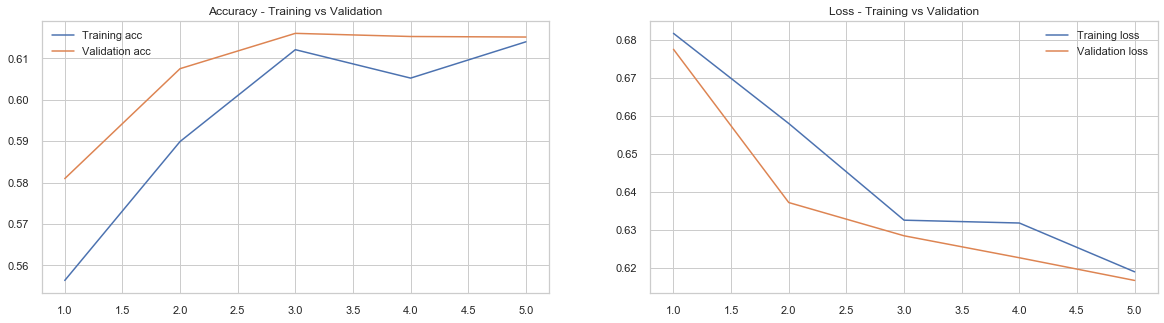

In [7]:
# check train and validation: loss & accuacy
sns.set(style="whitegrid")

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

fig, ax = plt.subplots(1, 2, figsize=(20, 5))
sns.lineplot(ax=ax[0], x=epochs, y=acc, label='Training acc')
sns.lineplot(ax=ax[0], x=epochs, y=val_acc, label='Validation acc')
ax[0].set_title("Accuracy - Training vs Validation")

sns.lineplot(ax=ax[1], x=epochs, y=loss, label='Training loss')
sns.lineplot(ax=ax[1], x=epochs, y=val_loss, label='Validation loss')
ax[1].set_title("Loss - Training vs Validation");

In [8]:
# evaluate model
scores = model.evaluate(x_test, y_test, verbose=1)
print("test loss: ", scores[0])
print("test acc: ", scores[1])

782/782 [==============================] - 27s 35ms/step - loss: 0.6180 - accuracy: 0.6099
test loss:  0.6180471777915955
test acc:  0.6098618507385254


### 3. Hyperparameters Tuning - Keras Tuner<a id='hyperparameters_keras_tuner'></a> 

[Sections](#sections_nlp_lstm)

This notebook focuses on a simple hyperparameters tuning. Expanding from the model training and evaluation results above, this section aims to enhance the LSTM performance by testing specifically on: different numbers of units and learning rates, while other parameters will remain as it is.

#### 3.1. Keras Tuner Setup & Run<a id='keras_tuner_setup_run'></a>

[Sections](#sections_nlp_lstm)

In [9]:
# build model
def build_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(top_words, 32, input_length=input_length))
    model.add(tf.keras.layers.LSTM(units=hp.Int('units',
                                        min_value=8,
                                        max_value=32,
                                        step=8), 
                                   dropout=0.2, recurrent_dropout=0.2))
    model.add(tf.keras.layers.Dense(1, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=tf.keras.optimizers.Adam(
        hp.Choice('learning_rate',  
                  values=[1e-2, 1e-3, 1e-4])),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [10]:
# define model
bayesian_opt_tuner = BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=3,
    executions_per_trial=1,
    overwrite=True
)

In [11]:
# run model
bayesian_opt_tuner.search(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

Trial 3 Complete [00h 23m 37s]
val_accuracy: 0.5

Best val_accuracy So Far: 0.8206400275230408
Total elapsed time: 00h 59m 39s
INFO:tensorflow:Oracle triggered exit


#### 3.2. Result Interpretation & Thoughts Sharing - Keras Tuner<a id='keras_tuner_result'></a>

[Sections](#sections_nlp_lstm)

In [12]:
# show result
bayesian_opt_tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
units: 16
learning_rate: 0.001
Score: 0.8206400275230408
Trial summary
Hyperparameters:
units: 16
learning_rate: 0.0001
Score: 0.795520007610321
Trial summary
Hyperparameters:
units: 32
learning_rate: 0.01
Score: 0.5


Keras Tuner will return a list of top-scored results after run through all combinations of different parameters. As this notebook does not fix the LSTM's hidden states and cell states initializers to provide the flexibility of testing different settings, the score may fluctuate a little; but the output set of optimal parameters are generally consistent in terms of the numbers of units and learning rate. With the current settings for original (unit: 32, learning rate: default) and trials (the number of units: 8,16,24,32 & learning rates: 0.01, 0.001, 0.0001), hyperparameters with 16 units and 0.001 learning rate returned the best result; which means the developers could use these results to tune the internal architecture provided considerations (e.g. speed-accuracy tradeoff an etc.) have taken into account. 

Often, the choices of which and what to be fine-tuned is tricky and subjective. Having said that, with some general understanding on the parameters' meanings and the problems' background would help determining which parameters and what thresholds are most likely to be tested. Also, with this knowledge, it gives a better picture when interpreting the results or deciding the cut-off point if the obtained parameters sets are sufficient to move onto the next stage. After all, the focus should be on solving the real-world problems.

#### 4. Wrap Up<a id='wrap_up_nlp_lstm'></a> 

[Sections](#sections_nlp_lstm)

**Discussion & Closing:**

Hyperparameters tuning is a very huge area on its own as it requires an extensive knowledge of multidisciplinary topics in order to select a set of optimal hyperparameters for a learning algorithm. Though the tuning process is time-consuming, it is one of the most crucial and unavoidable tasks in ML Algorithms selection. Thanks to the passion of solving the real-life problems, which has been inspiring fresh perspectives or different approaches and one of those is automated hyperparameters tuning. Automated hyperparameters tuning technique has greatly improved the researchers' productivity, especially when a great number of ideas are pending to be experimented while inherent and practical limitations remain (e.g. small data size, time and any sorts of restrictions). 

To wrap up, the objective of this notebook is to demo hyperparameters tuning with Keras Tuner in particular as well as the basic steps of building the LSTM model with the IMDB dataset. Hopefully, this brief presentation gives you some ideas on my skill sets in general. Once again, thank you for considering me.